In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from var_model import ClimateVAR
from sdice_model import SimplifiedDICE
from portfolio import PortfolioOptimizer

In [2]:
# Instancia para limpiar y procesar los datos climáticos
climate_cleaner = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx')
climate_data = climate_cleaner.clean_and_prepare_data()

# Instancia para limpiar y procesar los datos climáticos
economic_cleaner = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv')
economic_data = economic_cleaner.clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
assets = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP'] 
benchmark = '^GSPC'  
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data.drop('Date', axis=1, inplace=True)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Definir la función objetivo para Optuna
def objective(trial):
    # Elige el número de retardos entre 1 y 10
    maxlags = trial.suggest_int('maxlags', 1, 10)

    # Ajustar el modelo VAR con el número de retardos sugerido
    var_model = ClimateVAR(all_data)
    var_results = var_model.fit(maxlags=maxlags)

    # Realizar predicciones con el número de retardos sugerido
    predicted = var_model.predict(var_results, lags=maxlags, end=100)

    # Definir los valores reales (esto es solo un ejemplo, debes usar tus valores reales)
    actual = all_data[maxlags:100]  # Ajusta según la longitud de tus datos

    # Asegurarse de que predicted y actual tengan la misma longitud
    min_len = min(len(predicted), len(actual))
    predicted = predicted[:min_len]
    actual = actual[:min_len]

    # Calcular el error de predicción (RMSE)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    return rmse

# Crear el estudio de Optuna para minimizar el RMSE
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización
study.optimize(objective, n_trials=100)

# Imprimir el número óptimo de retardos
print(f'Número óptimo de retardos: {study.best_trial.params["maxlags"]}')
print(f'RMSE óptimo: {study.best_value}')

# Ajustar el modelo VAR con el número óptimo de retardos
optimal_maxlags = study.best_trial.params["maxlags"]
var_model = ClimateVAR(all_data)
var_results = var_model.fit(maxlags=optimal_maxlags)

# Realizar predicción futura con el número óptimo de retardos
predict = var_model.predict(var_results, lags=optimal_maxlags, end=100)

# Imprimir los valores predichos
print("Valores predichos:")
print(predict)

[I 2024-09-20 22:08:21,031] A new study created in memory with name: no-name-56cfb571-99c5-44f1-8c27-12508c0dc624
[I 2024-09-20 22:08:21,076] Trial 0 finished with value: 25.97835459770039 and parameters: {'maxlags': 5}. Best is trial 0 with value: 25.97835459770039.
[I 2024-09-20 22:08:21,087] Trial 1 finished with value: 4.426246763356351e-09 and parameters: {'maxlags': 7}. Best is trial 1 with value: 4.426246763356351e-09.
[I 2024-09-20 22:08:21,103] Trial 2 finished with value: 1.960288308716339e-08 and parameters: {'maxlags': 6}. Best is trial 1 with value: 4.426246763356351e-09.
[I 2024-09-20 22:08:21,106] Trial 3 finished with value: 35.123759194329374 and parameters: {'maxlags': 4}. Best is trial 1 with value: 4.426246763356351e-09.
[I 2024-09-20 22:08:21,117] Trial 4 finished with value: 6.628696802987052e-10 and parameters: {'maxlags': 8}. Best is trial 4 with value: 6.628696802987052e-10.
[I 2024-09-20 22:08:21,120] Trial 5 finished with value: 42.6702470257648 and parameter

Número óptimo de retardos: 8
RMSE óptimo: 6.628696802987052e-10
Valores predichos:
[[-6.61962755e-02 -7.69770524e-03  7.99097286e-02 ...  1.84016260e+04
   3.00000000e-02  2.38034000e+02]
 [-2.18162946e-02 -2.86219488e-02 -1.06396324e-01 ...  1.84016260e+04
   3.00000000e-02  2.38034000e+02]
 [ 8.34090321e-02 -4.03780173e-02  3.34970753e-01 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 ...
 [ 2.31830905e-02 -9.24476131e-02 -4.76351713e-02 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 1.18648854e-01  2.06355328e-01  2.85916996e-01 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 2.89871643e-02 -1.61853981e-02 -1.60551716e-01 ...  2.70630120e+04
   4.92000000e+00  3.03032000e+02]]


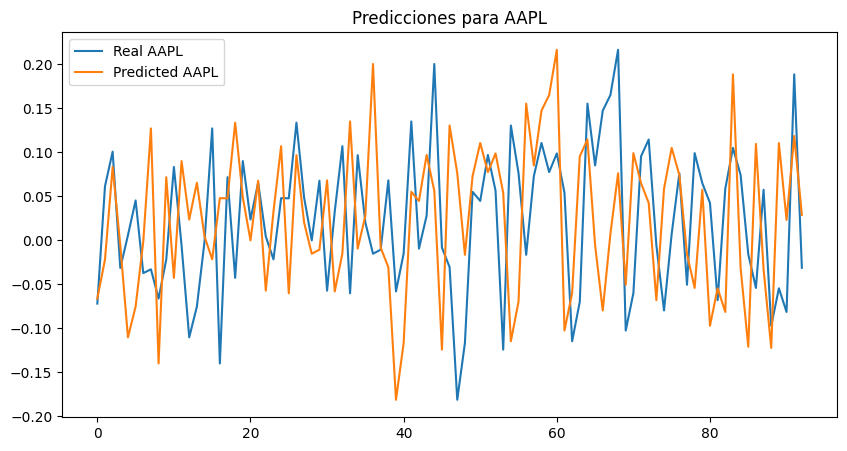

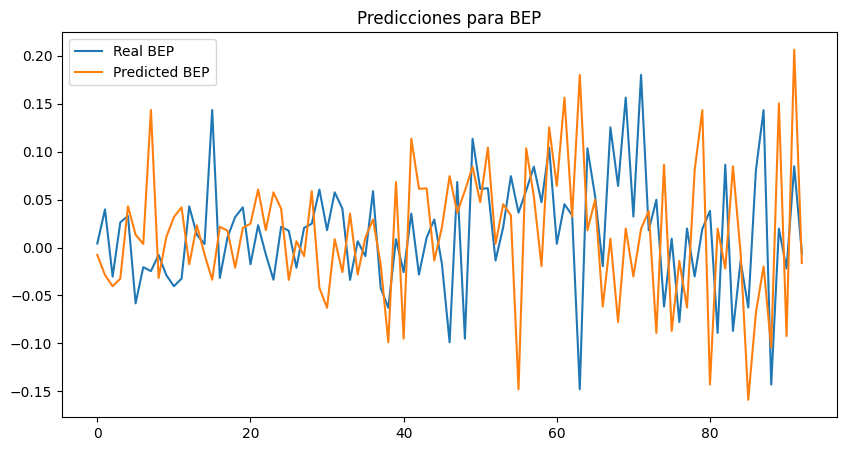

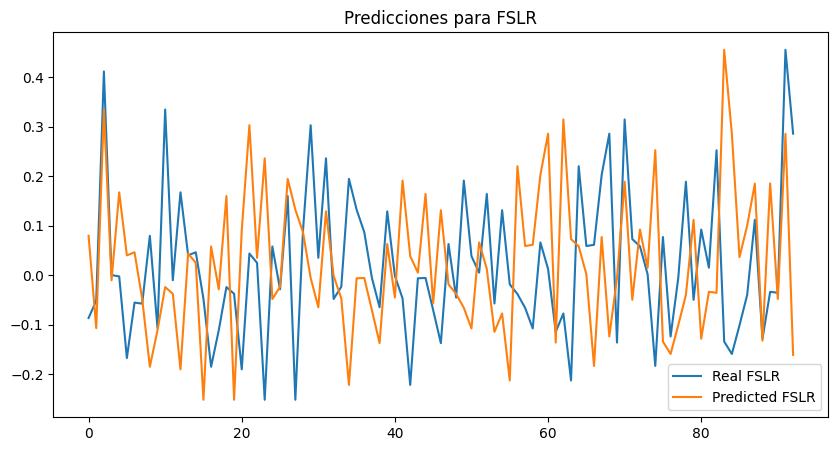

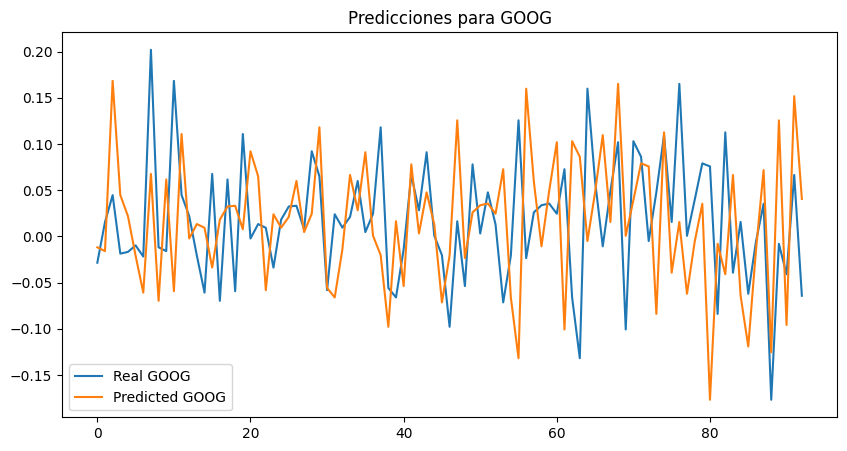

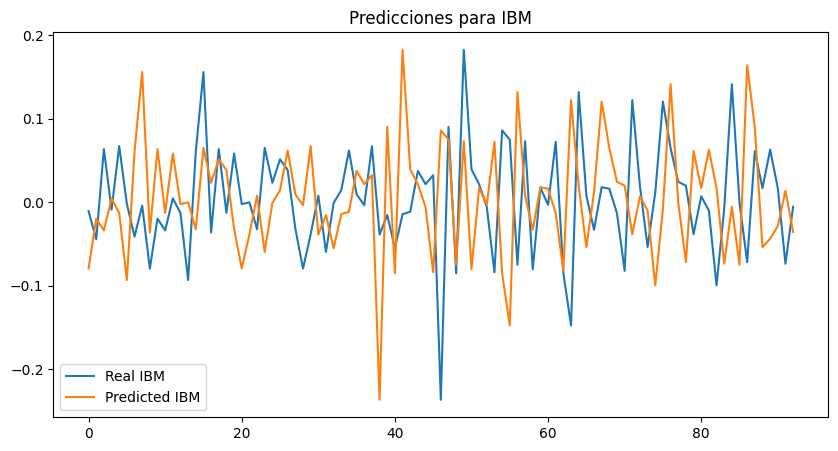

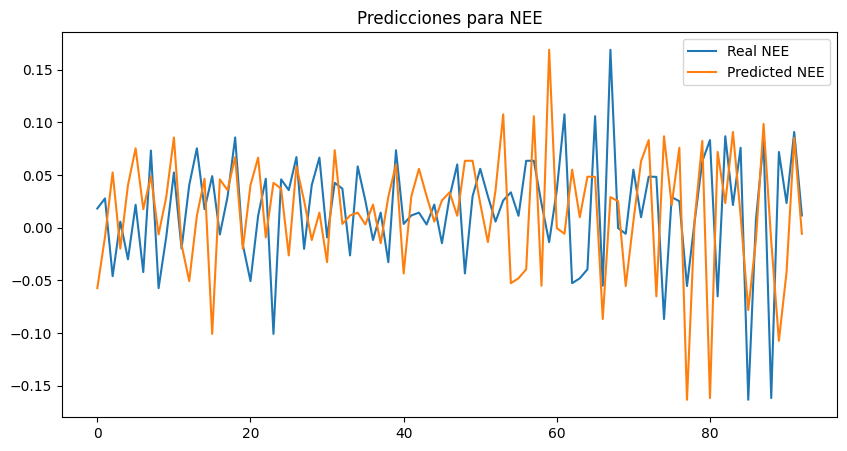

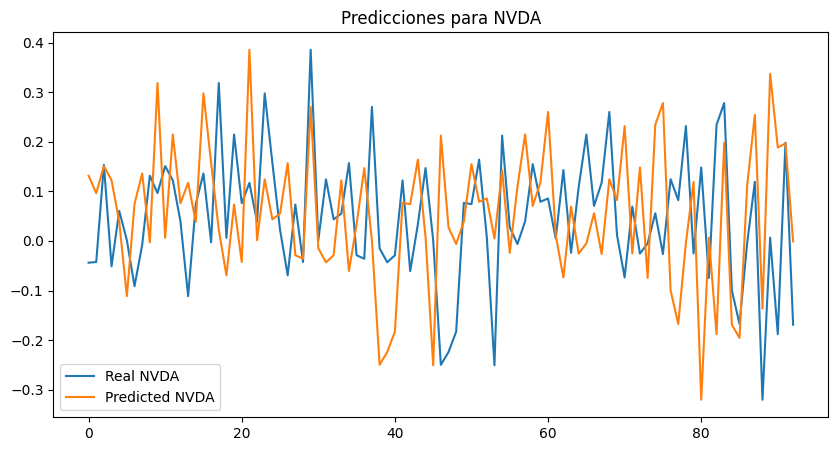

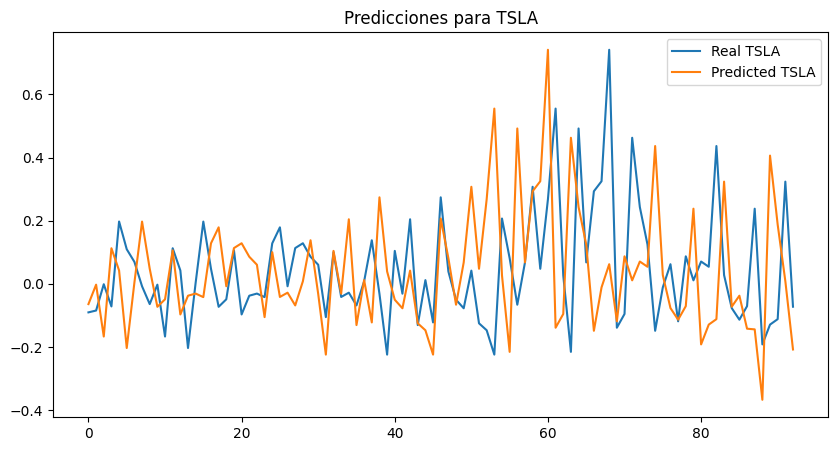

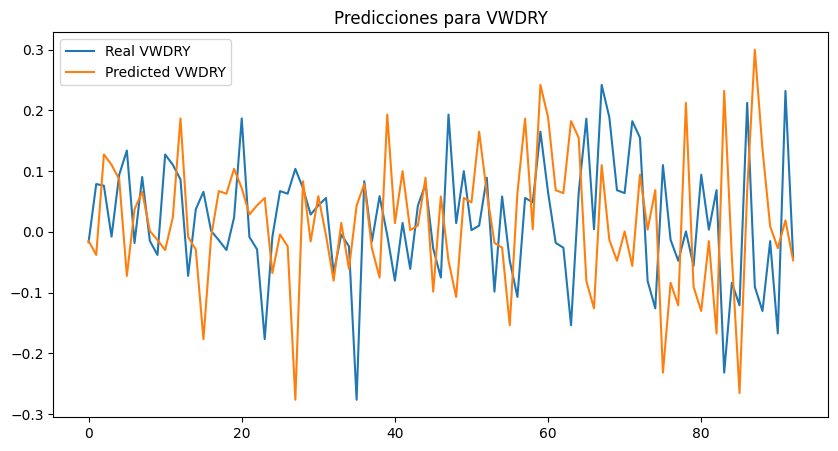

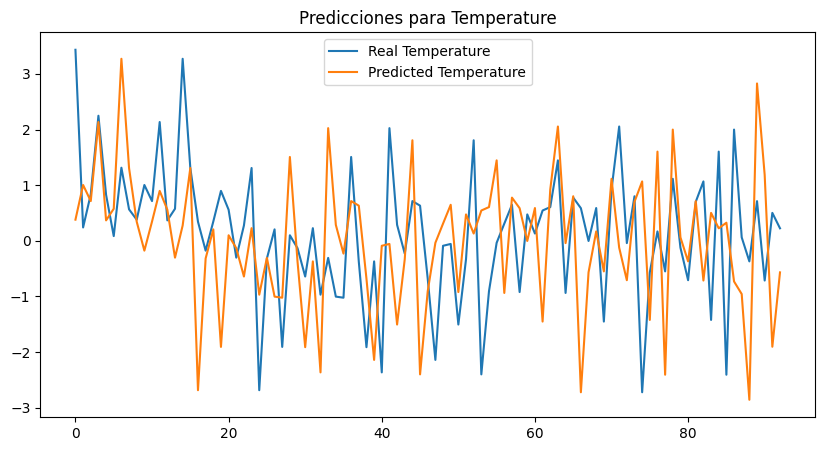

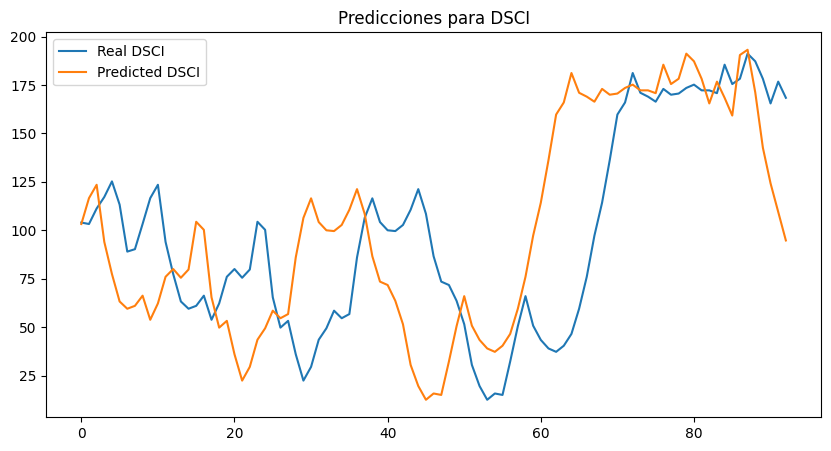

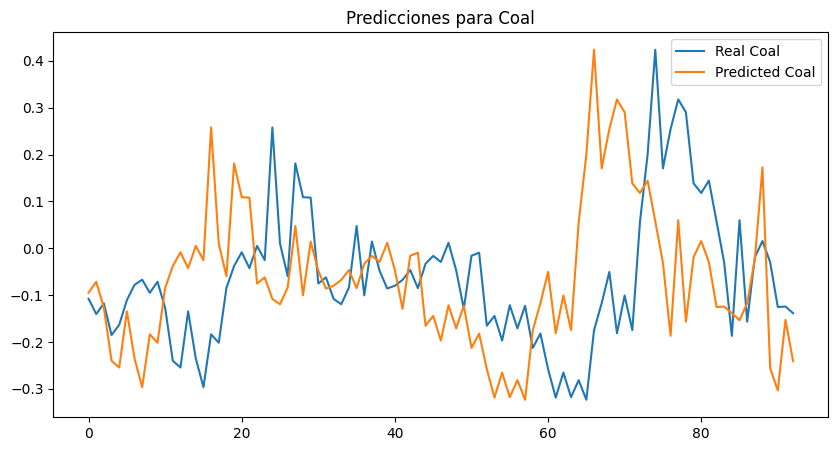

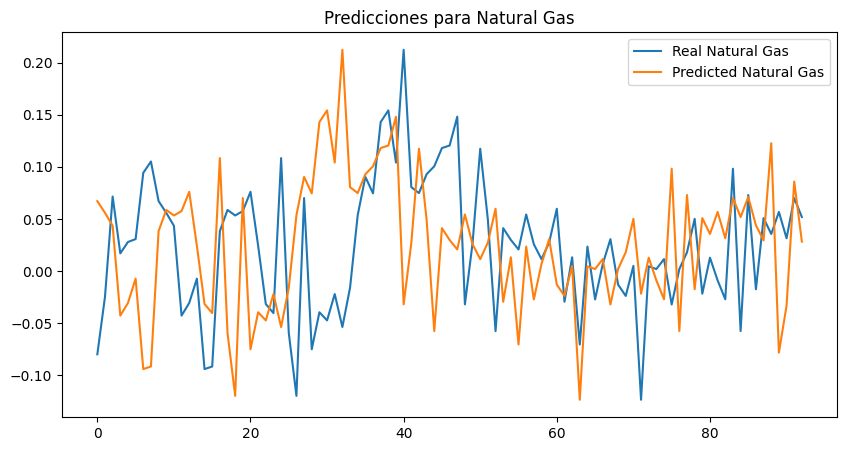

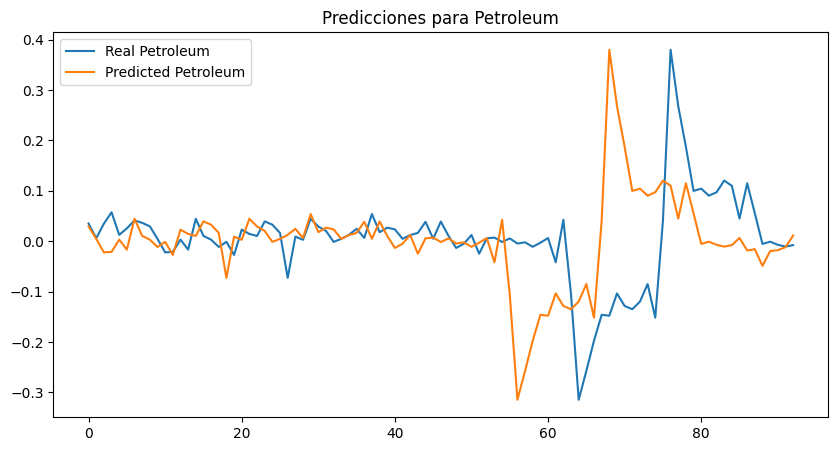

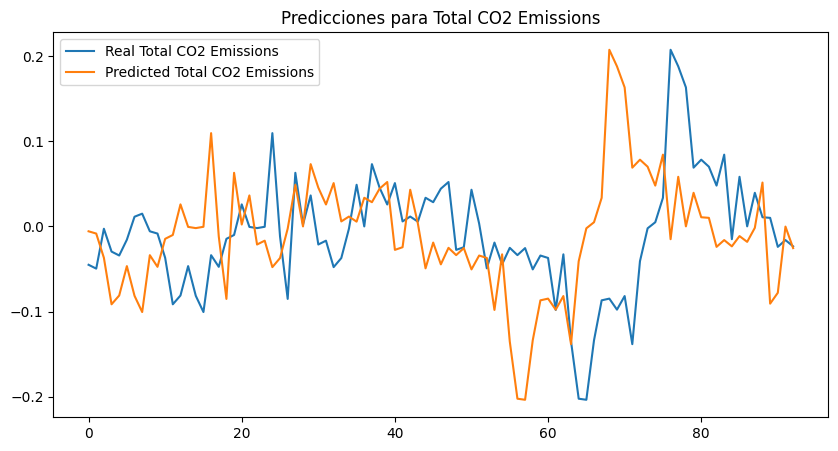

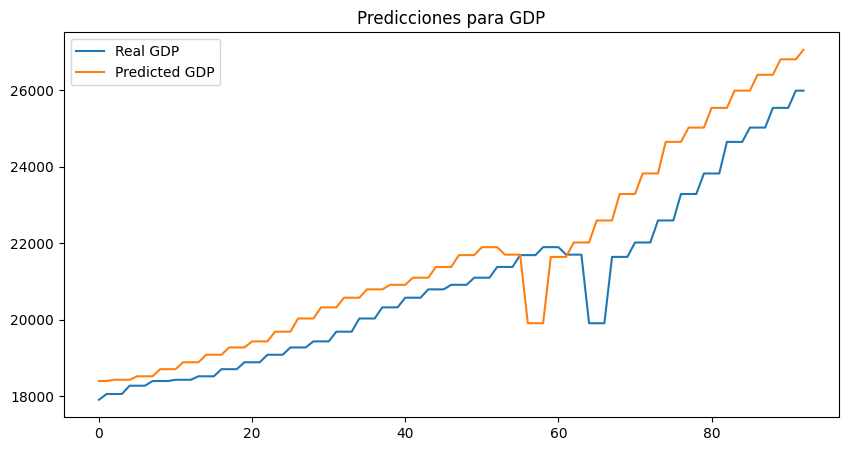

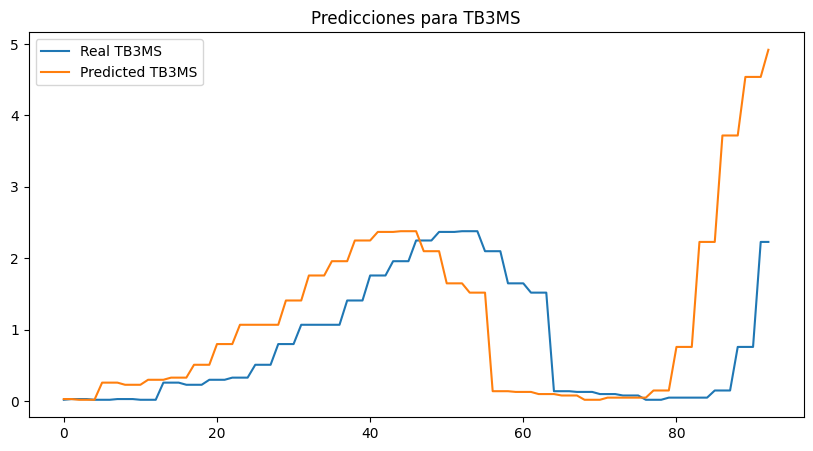

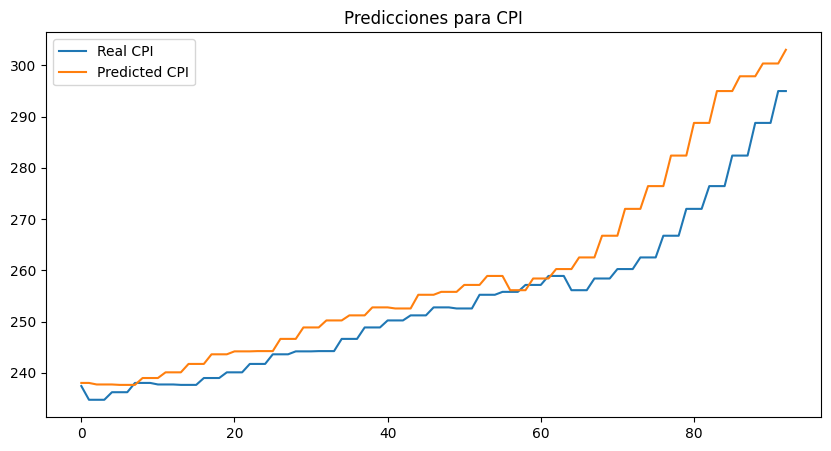

In [4]:
# Graficar las predicciones versus los datos originales
for i, column in enumerate(all_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(all_data.index[:len(predict)], all_data.iloc[:len(predict), i], label=f"Real {column}")
    plt.plot(all_data.index[:len(predict)], predict[:, i], label=f"Predicted {column}")
    plt.title(f"Predicciones para {column}")
    plt.legend()
    plt.show()

Pesos óptimos del portafolio (sharpe): [5.37897841e-17 0.00000000e+00 0.00000000e+00 5.90425810e-17
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.18066972e-16]


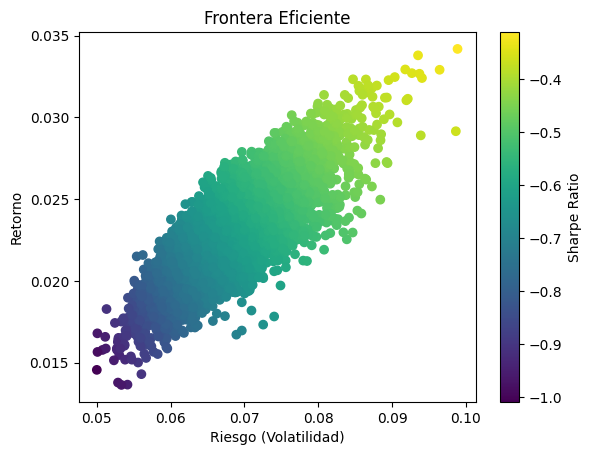

Pesos óptimos del portafolio (sortino): [0.00000000e+00 0.00000000e+00 8.32667268e-17 0.00000000e+00
 1.00000000e+00 0.00000000e+00 3.26622697e-16 6.26324817e-17
 4.86488995e-16]


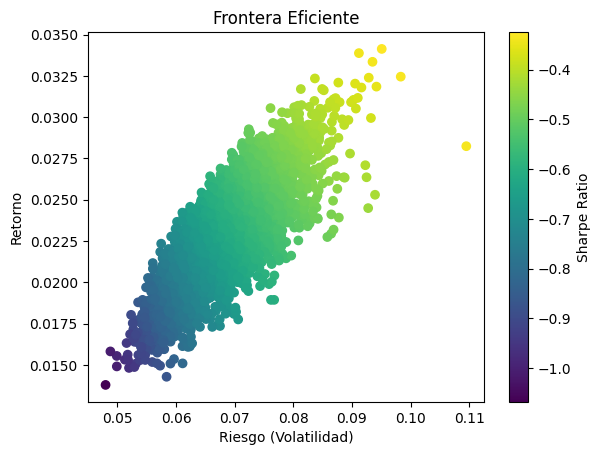

Pesos óptimos del portafolio (omega): [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]


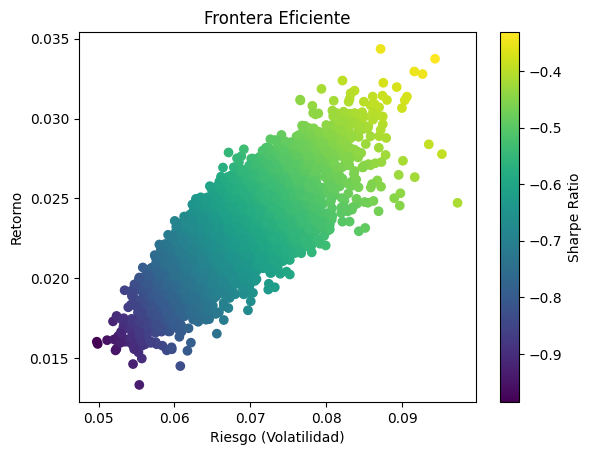

In [5]:
# Implementación para la generación de portafolios
def generate_portfolios_with_climate_and_economic_data(all_data, expected_returns, cov_matrix, risk_free_rate, strategy="sharpe"):
    """
    Genera portafolios utilizando datos financieros, climáticos y económicos,
    y optimiza el portafolio basado en la estrategia seleccionada (Sharpe, Sortino, Omega).
    
    :param all_data: DataFrame con todos los datos combinados (financieros, climáticos y económicos).
    :param expected_returns: Retornos esperados de los activos financieros (acciones).
    :param cov_matrix: Matriz de covarianzas de los activos financieros.
    :param risk_free_rate: Tasa libre de riesgo.
    :param strategy: Estrategia de optimización ("sharpe", "sortino", "omega").
    :return: Pesos óptimos y la gráfica de la frontera eficiente.
    """
    # Filtrar las columnas que corresponden a los activos (acciones) y que serán las únicas con pesos asignados
    financial_columns = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP']  # Ejemplo
    asset_data = all_data[financial_columns]
    
    # Encontrar las posiciones numéricas de las columnas financieras en all_data
    financial_indices = [all_data.columns.get_loc(col) for col in financial_columns]
    
    # Los retornos esperados y la matriz de covarianzas solo deben calcularse para las acciones (usando los índices)
    expected_returns_assets = expected_returns[financial_indices]
    cov_matrix_assets = cov_matrix[np.ix_(financial_indices, financial_indices)]
    
    # Inicializar optimizador de portafolios con la estrategia seleccionada
    optimizer = PortfolioOptimizer(expected_returns_assets, cov_matrix_assets, risk_free_rate)
    
    # Optimizar el portafolio para la estrategia seleccionada
    optimal_weights = optimizer.optimize_portfolio(strategy=strategy)
    print(f"Pesos óptimos del portafolio ({strategy}):", optimal_weights)
    
    # Graficar la frontera eficiente
    optimizer.plot_efficient_frontier(num_portfolios=5000)
    
    return optimal_weights

# Supongamos que ya has ajustado el modelo VAR y generado predicciones:
# expected_returns y cov_matrix provienen de las predicciones VAR.
# Valores de ejemplo:
risk_free_rate = 0.065  # Tasa libre de riesgo ajustable
expected_returns = np.mean(predict, axis=0)  # Calculado de las predicciones del VAR
cov_matrix = np.cov(predict, rowvar=False)   # Matriz de covarianza de las predicciones

# Generación de portafolios y optimización con diferentes estrategias
optimal_weights_sharpe = generate_portfolios_with_climate_and_economic_data(all_data, expected_returns, cov_matrix, risk_free_rate, strategy="sharpe")
optimal_weights_sortino = generate_portfolios_with_climate_and_economic_data(all_data, expected_returns, cov_matrix, risk_free_rate, strategy="sortino")
optimal_weights_omega = generate_portfolios_with_climate_and_economic_data(all_data, expected_returns, cov_matrix, risk_free_rate, strategy="omega")
